In [9]:
#IMPORTS
import pandas as pd
import luxpy as lx # package for color science calculations 
# print('Luxpy version: ',lx.__VERSION__)
# version: v1.9.6
import numpy as np # fundamental package for scientific computing 
import matplotlib.pyplot as plt # package for plotting
import copy #package for deep copy of arrays
from scipy import interpolate
from luxpy.toolboxes import spdbuild as spb

from DMXEnttecPro import Controller #package to control the luminaire color output
from luxpy.toolboxes import spectro as sp
from luxpy.toolboxes.spectro import jeti as jeti #for jeti

In [19]:
#ILLUMINANCE AND DATA LOADING
def load_data(filepath):
    # load data from a txt file and put it into a pandas dataframe  
    # input: filepath: path to the file that's being loaded
    # output: dataframe with data
    
    """
    data columns: 
    Channel(1,2,3,5 = r,g,b,a) 
    Driver(0-255, 5 steps)  
    Value(2-dimension array consisiting of wavelenghts and spectral radiance per wavelength)
    Luminance(luminance values per driver per channel)
    """
    
    spdData = pd.read_csv(filepath, sep=' |:', header=None, engine='python')
    spdData.columns = ['Channel','Driver','Value']
    # calculate luminance data per driver from spectral radiance
    spdData['Luminance'] = spdData.apply(lambda x: float(lx.spd_to_power(eval(x['Value']), ptype='pu')), axis=1)
    return spdData

def get_per_channel_luminance(spdData, i, driver, luminance):
    # for each channel (R,G,B,A) get each luminance per driver (0-255) from the dataframe
    # input: spdData: dataframe with data, i: channel value, driver: drivers array, luminance: luminances array
    # output: driver: driver array, luminance: luminance array
    
    for j in range(0,256,5):
        driver.append(j)
        luminance.append(spdData['Luminance'][spdData['Channel']==i][spdData['Driver']==j])
    return driver, luminance
    
def get_luminance(spdData, channels):
    # get interpolated luminance for each channel
    # input: spdData: dataframe with data, channels: channels array
    # output: interpolation_funcs: array ofinterpolation functions of luminance for each channel, 
    #         largestLum: array of largest luminances per channel
    
    largestLum = []
    interpolation_funcs = []
    for i in channels:
        driver = []
        luminance = []
        col = np.where(i==1, 'r', np.where(i==2, 'g', np.where(i==3, 'b', 'y')))
        driver, luminance = get_per_channel_luminance(spdData, i, driver, luminance)
        largestLum.append(float(luminance[-1]))    # record the largest luminance of every channel

        x = np.array(driver)
        y = np.array(luminance) 
        interpolation_funcs.append(interpolate.UnivariateSpline(y,x,s=0)) # interpolation: pass all the points
    largestLum.insert(3,None) # To easily process in function of ChannelValue
    interpolation_funcs.insert(3,None) #insert None for white (w) channel
    return interpolation_funcs, largestLum

def plot_luminance(spdData, channels):
    # plot luminance per channel
    # input: spdData: dataframe with data, channels: channels array
    
    for i in channels:
        driver = []
        luminance = []
        col = np.where(i==1, 'r', np.where(i==2, 'g', np.where(i==3, 'b', 'y')))
        driver, luminance = get_per_channel_luminance(spdData,i, driver, luminance)
        plt.plot(driver,luminance,str(col),label='channel:'+str(col))
        plt.legend()
        plt.xlabel('Value')
        plt.ylabel('Luminance[cd/m^2]')
        plt.title('Relation between Value of Driver and Luminance')
        plt.show    #plot

def ChannelValue(l:int, perc:float, largestLum): 
    # get driver value for specific channel
    # input: l:channel(R-1,G-2,B-3,A-5), perc:the percentage of the maximum luminance of the channel
    #        largestLum: largest luminance per channel
    # output: the channel value(0-255)
    return int(interpolation_funcs[l-1](perc*largestLum[l-1]))   

def get_drivers(channels, w, largestLum):
    # get values for driver for each channel per given weight
    # input: channels: channels array, w: array of weights(percentages) of each channel
    #        largestLum: largest luminance per channel
    # output: digit: array of the driver values needed for the target color
    
    digit = []
    for channel,i in zip(channels, range(len(w))):
        if channel is not None:
            digit.append(ChannelValue(channel, w[i], largestLum))
    return digit

In [14]:
#3 AND N COLOR MIXING
def get_primaries(spdData, channels):
    # get spds of primary colors for color mixing
    # input: spdData: dataframe with data, channels: channels array
    # output: primaries: array of primary colors
    
    primaries = [None] * 5
    for i in channels:
        primaries[i-1] = np.array(eval(spdData['Value'][(spdData['Channel'] == i) & (spdData['Driver'] == 255)].values[0]))

    return primaries

def get_cp(primaries, cieobs= '1931_2'):
    # get XYZ array of color primaries
    # input: primaries: array of color primaries, cieobs: type of color matching functions to use
    # output: XYZ array of primaries where each primary has it's own column
    
    cp = []
    for primary in primaries:
        if primary is not None:
            cp.append(lx.spd_to_xyz(primary, relative= False, cieobs=cieobs)[0])
    
    return np.array(cp).T

def get_target_color_xyz(type_calc, cieobs= '1931_2',spd = None, cct = None, duv= None, Lum= None):
    # get XYZ of target color  
    # input: type_calc: defines from what we're calcuclating XYZ value(spd, cct...), cieobs: type of color matching functions to use
    #        spd: spectral power distribution, cct: corelated color temperature of target color, duv: duv, 
    #        Lum: luminance of target color
    # output: XYZ of the target color
    
    if type_calc == 'cct,duv':
        xyzt_cct_test_scaled = lx.cct_to_xyz(cct, duv, cieobs=cieobs) 
        xyzt = Lum*xyzt_cct_test_scaled/100 #relative to absolute
    else:
        # xyzt = lx.spd_to_xyz(spd, relative= False, cieobs=cieobs)
        xyzt = np.array([[51.8347, 42.0302, 78.0537]])
    return xyzt
    
def get_target_color_yxy(type_calc, cieobs= '1931_2',spd = None, cct = None, duv= None, Lum= None):
    # get Yxy of target color 
    # input: type_calc: defines from what we're calcuclating Yxy value(spd, cct...), cieobs: type of color matching functions to use
    #        spd: spectral power distribution, cct: corelated color temperature of target color, duv: duv, 
    #        Lum: luminance of target color
    # output: Yxy of the target color
    
    if type_calc == 'cct,duv':
        xyzt_cct_test_scaled = lx.cct_to_xyz(cct, duv, cieobs=cieobs)
        xyzt_cct_test = Lum*xyzt_cct_test_scaled/100 #relative to absolute
        Yxyt = lx.xyz_to_Yxy(xyzt_cct_test)
    else:
        # xyzt = lx.spd_to_xyz(spd, relative= False, cieobs=cieobs)
        xyzt = np.array([[51.8347, 42.0302, 78.0537]])
        Yxyt = lx.xyz_to_Yxy(xyzt) 
    return Yxyt

#3-channel color mixing
def three_color_mixing(cp, xyzt):
    # 3-channel color mixing using Grassmann’s law of additivity and proportionality
    # input: cp: XYZ array of color primaries, xyzt: XYZ value of the target color
    # output: w: array of weights for each channel
    
    cp = cp[:,:3]
    print("Color primaries: ",cp)
    print("XYZ value of the target color: ", xyzt)
    w = np.linalg.inv(cp) @ xyzt.T
    
    # check if calculated weights are correct
    print(w[0]*cp.T[0] + w[1]*cp.T[1] + w[2]*cp.T[2])
    return w
    
#N color mixing
def n_color_mixing(cp, xyzt):
    # N-channel color mixing using Moore-Penrose pseudo-inverse without any additional constraints
    # input: cp: XYZ array of color primaries, xyzt: XYZ value of the target color
    # output: w: array of weights for each channel
    
    w = cp.T @ (np.linalg.inv(cp@cp.T)) @ xyzt.T
    
    # check if calculated weights are correct
    print(w[0]*cp.T[0] + w[1]*cp.T[1] + w[2]*cp.T[2] + w[3]*cp.T[3])
    return w

In [15]:
#OPTIMIZATION
def spd_to_cris(spd, solution_info=None):
    # obj_fcn to optimize per Rf, Rg
    # input: spd: input spd
    # output: rf, rg values of spd 
    
    Rf,Rg = lx.cri.spd_to_cri(spd, cri_type='ies-tm30',out='Rf,Rg')
    return np.vstack((Rf, Rg))  


def spd_to_lers(spd, cieobs='1931_2', solution_info=None):
    # obj_fcn to optimize per ler
    # input: spd: input spd, cieobs: type of color matching function to use
    # output: luminous efficacy of spd 
    
    ler = lx.spd_to_ler(spd, cieobs=cieobs)
    return ler 


def spd_to_ccts(spd, cieobs, solution_info=None):
    # obj_fcn to optimize per cct and duv
    # input: spd: input spd, cieobs: type of color matching function to use
    # output: cct and duv values of spd
    
    xyz = lx.spd_to_xyz(spd, relative=False, cieobs=cieobs)
    cct,duv = lx.xyz_to_cct(xyz, out = 'cct,duv')
    return np.vstack((cct, duv))  

def spd_to_ciera(spd, solution_info=None):
    # obj_fcn to optimize per cct and duv
    # input: spd: input spd, cri_type: type of color fidelity model to use
    # output: ra value of spd
    
    ra = lx.cri.spd_to_cri(spd, cri_type = 'ciera')
    return ra

def make_obj_fun(opt_par, tar_vals):
    # make obj_fun for optimization
    # input: opt_par: parameter used for optimization (cct,duv,rf,rg...), tar_vals: target values for optimization
    # output: obj_fcn: object function used for optimization, obj_tar_vals: list of target values
    
    if opt_par == 'cct,duv':
        obj_fcn = [(spd_to_ccts,'cct', 'duv')]
        obj_tar_vals = [tar_vals]
    elif opt_par == 'rf,rg':
        obj_fcn = [(spd_to_cris,'Rf','Rg')]
        obj_tar_vals = [tar_vals]
    elif opt_par == 'ler':
        obj_fcn = [(spd_to_lers,'ler')]
        obj_tar_vals = [tar_vals]
    elif opt_par == 'ra':
        obj_fcn = [(spd_to_ciera,'ra')]
        obj_tar_vals = [tar_vals]
    return obj_fcn, obj_tar_vals


def do_optimization(cieobs, primaries, method, ct):
    # perform optimization
    # input: cieobs: type of color matching function to use, primaries: array of color primaries,
    #        method: method used for minimizer, ct: Yxy value of target color
    # output: M[0]: array of weights for each channel

    #make an ndarray of primaries
    prims = np.array([primaries[0][0]])
    for i in primaries:
        if i is not None:
            prims = np.append(prims, [i[1]], axis=0)
    
    print("Color primaries: ", prims)

    target = ct
    so3 = spb.SpectralOptimizer(target = target, tar_type = 'Yxy', cspace_bwtf = {},
                          wlr = [360,830,1], cieobs = cieobs, 
                          out = 'spds,primss,Ms,results',
                          optimizer_type = '3mixer', triangle_strengths_bnds = None,
                          prim_constructor = None, 
                          prims = prims,
                          obj_fcn = spb.ObjFcns(f=obj_fcn, ft = obj_tar_vals),
                          minimizer = spb.Minimizer(method=method),
                          verbosity = 0)

    # start optimization:
    S,M = so3.start(out = 'spds,Ms')
  
    # Check output agrees with target:
    xyz = lx.spd_to_xyz(S, relative = False, cieobs = cieobs)
    Yxy = lx.xyz_to_Yxy(xyz)
    cct,duv = lx.xyz_to_cct(xyz, cieobs = cieobs,out = 'cct,duv')
    Rf, Rg = spd_to_cris(S)
    ler = spd_to_lers(S, cieobs)
    ra = spd_to_ciera(S)
    print('\nResults (optim,target):')
    print("Yxy: ([{:1.0f},{:1.2f},{:1.2f}],[{:1.0f},{:1.2f},{:1.2f}])".format(Yxy[0,0],Yxy[0,1],Yxy[0,2],target[0,0],target[0,1],target[0,2]))
    print("Rf: ({:1.2f})".format(Rf[0]))
    print("Rg: ({:1.2f})".format(Rg[0]))
    print("cct(K), duv: ({:1.1f},{:1.4f})".format(cct[0,0], duv[0,0]))
    print("LER: ", ler)
    print("Ra: ", ra)
    
    print('\nFlux ratios of component spectra:', M)

    #plot spd:
    plt.figure()
    lx.SPD(S).plot()

    return M[0]

In [20]:
def p_test(xyzt, xyzm):
    # test p-value to see if the number same or not
    # input: xyzt: Yxy value of tested data(presetted), xyzm: Yxy value of measured data
    xyzt = np.array(xyzt)
    xyzm = np.array(xyzm)
    p,T2 = lx.deltaE.discrimination_hotelling_t2(xyzt,xyzm, Y1 = 10.69, Y2=10.69, etype = 'fmc2', ellipsoid = False, cspace = 'Yxy')
    print('T2 values: ', T2)
    print('p-values: ', p)
    print('p < 0.05: ', p < 0.05)
    v1 = lx.deltaE.get_discrimination_ellipse(Yxy = xyzt, etype = 'fmc2', nsteps = 1, Y = 10.69) # v for 1-step ellipse
    v2 = lx.deltaE.get_discrimination_ellipse(Yxy = xyzm, etype = 'fmc2', nsteps = 1, Y = 10.69) # v for 1-step ellipse
    scale = lx.utils.sp.stats.chi2.ppf(1-0.05,2)**0.5 # get scale factor for 95% confidence ellipses
    print('\n Ellipse 95%-scale-factor = ', scale)
    v1[:,:2] *= scale
    v2[:,:2] *= scale
    
    axh = lx.plotSL(cspace = 'Yxy', cieobs = '1931_2', show = False, diagram_colors = False)
    axh = lx.plotellipse(v1, axh = axh, plot_center = False,  out = 'axh', line_style = '--', line_color ='g', line_width = 2, center_color = 'g')
    color = 'r' if p < 0.05 else 'b'
    lx.plotellipse(v2,  axh = axh,  line_color = color, line_style = ':', plot_center = True, center_color = color)
    axh.set_xlim([xyzt[0][1]-0.05,xyzt[0][1]+0.05]);
    axh.set_ylim([xyzt[0][2]-0.05,xyzt[0][2]+0.05]);


def color_check_FMC(xyzt, xyzm):
    # To check the similarity of test color and measured color by FMC2
    # input: xyzt: Yxy value of tested data(presetted), xyzm: Yxy value of measured data
    xyzt = np.array(xyzt)
    xyzm = np.array(xyzm)

    vt = lx.deltaE.get_discrimination_ellipse(Yxy = xyzt, etype = 'fmc2', nsteps = 10, Y = 10.69) # v for 10-step ellipse
    vm = lx.deltaE.get_discrimination_ellipse(Yxy = xyzm, etype = 'fmc2', nsteps = 10, Y = 10.69) # v for 10-step ellipse

    axh = lx.plotSL(cspace = 'Yxy', cieobs = '1931_2', show = False, diagram_colors = True)
    axh = lx.plotellipse(vt, axh = axh, plot_center = False,  out = 'axh', line_style = '--', line_color ='g', line_width = 2, center_color = 'g')
    lx.plotellipse(vm, axh = axh,  line_color = 'w', line_style = ':', plot_center = True, center_color = 'w')
    axh.set_xlim([xyzt[0][1]-0.05,xyzt[0][1]+0.05]);
    axh.set_ylim([xyzt[0][2]-0.05,xyzt[0][2]+0.05]);

def color_check_macadam(xyzt, xyzm):
    # To check the similarity of test color and measured color by Macadam
    # input: xyzt: Yxy value of tested data(presetted), xyzm: Yxy value of measured data
    xyzt = np.array(xyzt)
    xyzm = np.array(xyzm)
    
    vt = lx.deltaE.get_macadam_ellipse(xy = [[xyzt[0][1],xyzt[0][2]]], nsteps = 10) # 10-step ellipse
    vm = lx.deltaE.get_macadam_ellipse(xy = [[xyzm[0][1],xyzm[0][2]]], nsteps = 10) # 10-step ellipse
    axh = lx.plotSL(show = False, diagram_colors = True, cspace = 'Yuv')
    lx.plotellipse(vt, axh = axh, show = True, cspace_out = 'Yuv',\
            line_style = '--', line_color ='g', line_width = 2,\
            plot_center = True, center_marker = '.', center_color = 'g', center_markersize = 6)
    lx.plotellipse(vm, axh = axh, show = True, cspace_out = 'Yuv',\
            line_style = ':', line_color ='w', line_width = 1.5,\
            plot_center = True, center_marker = '.', center_color = 'w', center_markersize = 6)

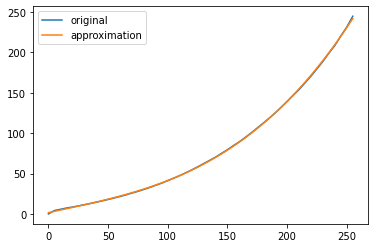

In [17]:
# Approximation
def getApproximation(x, y, n):
    apx = np.polyfit(x, y, n)
    y_apx = np.poly1d(apx)(x)
    return (x, y_apx)

channel = 1
x = range(0,256,5)
y = spdData['Luminance'][spdData['Channel']==channel]
x, y_apx = getApproximation(x, y, 3)

plt.plot(x, y, label='original')
plt.plot(x, y_apx, label='approximation')
plt.legend()
plt.show()

Color primaries:  [[3.6000e+02 3.6100e+02 3.6200e+02 ... 8.2800e+02 8.2900e+02 8.3000e+02]
 [4.7611e-04 9.4778e-05 2.9980e-05 ... 0.0000e+00 1.4012e-05 2.4236e-05]
 [1.2249e-04 0.0000e+00 3.3913e-04 ... 0.0000e+00 1.4301e-05 1.1742e-05]
 [4.3861e-04 7.4021e-05 0.0000e+00 ... 2.7768e-05 9.2454e-05 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 ... 2.6865e-06 8.9450e-06 0.0000e+00]]

Results (optim,target):
Yxy: ([50,0.40,0.43],[50,0.40,0.43])
Rf: (81.20)
Rg: (98.84)
cct(K), duv: (4000.0,0.0200)
LER:  [[3.6599e+02]]
Ra:  [[8.4375e+01]]

Flux ratios of component spectra: [[3.4037e-02 4.8559e-02 8.8330e-03 5.0858e-02]]
Driver values:  [19, 27, 3, 28]


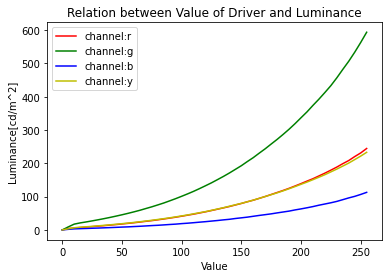

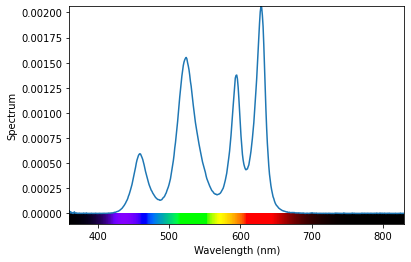

In [18]:
#CALCULATION

spdData = load_data('./data/spectrums2.txt')
channels = spdData['Channel'].unique()
interpolation_funcs, largestLum = get_luminance(spdData, channels)
plot_luminance(spdData, channels)

primaries = get_primaries(spdData,channels)
#cp = get_cp(primaries)
#ct = get_target_color_xyz('spd')
ct = get_target_color_yxy('cct,duv', cct= 4000, duv = 0.02, Lum = 50)
#w = three_color_mixing(cp, ct)
#w = n_color_mixing(cp, ct)
obj_fcn, obj_tar_vals = make_obj_fun('rf,rg', (90,110))
w = do_optimization('1931_2', primaries, 'particleswarm', ct)
digit = get_drivers(channels, w, largestLum)

print('Driver values: ', digit)


XYZ value of jeti spd:  [[4.4198e+01 4.9901e+01 1.1230e+01]]
Yxy value of jeti spd:  [[4.9901e+01 4.1962e-01 4.7376e-01]]
CCT, duv:  (array([[3.7744e+03]]), array([[2.9488e-02]]))
T2 values:  [1.0617e+01]
p-values:  [4.9490e-03]
p < 0.05:  [ True]

 Ellipse 95%-scale-factor =  2.447746830680816


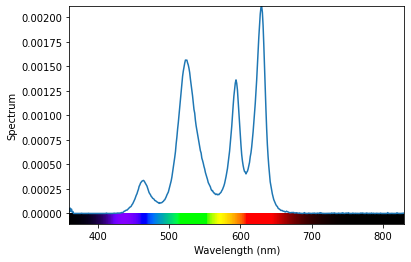

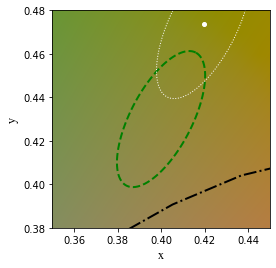

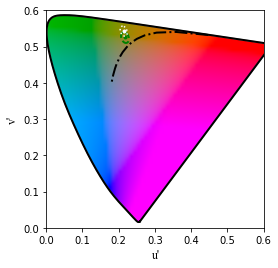

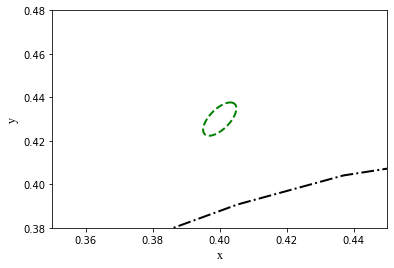

In [323]:
Yxyt = [[50,0.40,0.43]] #test color

dmx = Controller('COM8')  # Typical of Windows

dmx.set_channel(1, 19)  # Sets DMX channel 1 

dmx.submit()
dmx.set_channel(2, 27)  # Sets DMX channel 2

dmx.submit()
dmx.set_channel(3, 3)  # Sets DMX channel 3

dmx.submit()
dmx.set_channel(5, 28)  # Sets DMX channel 4

dmx.submit()

sp.jeti.set_laser(laser_on=True) #turning the laser on. The laser points to the target
# #sp.jeti.set_laser(laser_on=False)
spd = sp.get_spd('jeti') #passing device name to get_spd function
lx.SPD(spd).plot() #plotting the spd
xyzm = lx.spd_to_xyz(spd, relative=False) #get XYZ value
#Yuv = lx.xyz_to_Yuv(xyz)
print("XYZ value of jeti spd: ", xyzm)
Yxym = lx.xyz_to_Yxy(xyzm) #get Yxy value
print("Yxy value of jeti spd: ", Yxym)
print("CCT, duv: ", lx.xyz_to_cct(xyzm, out = 'cct,duv'))

color_check_FMC(Yxyt, Yxym)
color_check_macadam(Yxyt, Yxym)
p_test(xyzt, xyzm)